In [140]:
import pandas as pd
import numpy as np
import pickle
from extracting import *
from matplotlib import pyplot as plt

In [3]:
import torch
device = torch.device("cuda:0")

In [4]:
seq_len = 10
vector_len = 64

In [5]:
with open('mini_wordlist.bf', 'rb') as f:
    wordlist = pickle.load(f)

In [6]:
wordlist_dict = dict([
    (wordlist['word'][i], torch.tensor(wordlist['vector'][i])) for i in range(len(wordlist))
])

In [7]:
def exist_filter(words):
    return [w for w in words if w in wordlist_dict]

def prepare(line):
    extracted = extract(line)
    seq = exist_filter(extracted) + ['<end>']
    if len(seq) >= seq_len:
        seq = seq[len(seq) - seq_len:]
    else:
        seq += ['<empty>'] * (seq_len - len(seq))
    return seq

def prep_to_matrix(prep):
    return vectorize(prep)

def word2vec(word):
    idx = np.where(wordlist['word'] == word)[0][0]
    return wordlist['vector'][idx]

def line_to_matrix(line):
    extracted = extract(line)
    seq = exist_filter(extracted) + ['<end>']
    if len(seq) >= seq_len:
        seq = seq[len(seq) - seq_len:]
    else:
        seq += ['<empty>'] * (seq_len - len(seq))
    return [
        word2vec(w) for w in seq
    ]
    
cosine_similarity = torch.nn.CosineSimilarity(dim=0, eps=1e-5)

def get_most_similar(vec):
    mp = wordlist['word'].apply(lambda x: cosine_similarity(vec, wordlist_dict[x]))
    idx = np.argmax(mp)
    return wordlist.iloc[idx]['word']

In [8]:
class TimeDistributed(torch.nn.Module):
    def __init__(self, module, batch_first=False):
        super(TimeDistributed, self).__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)
        x_reshape = x.contiguous().view(-1, x.size(-1))
        y = self.module(x_reshape)
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))
        else:
            y = y.view(-1, x.size(1), y.size(-1))
        return y

In [148]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.last_output = None
        self.x_train = []
        self.y_train = []
        self.max_train_size = 75
        self.learn_rate = 100
        self.rnn1 = torch.nn.LSTM(vector_len, vector_len, 1, batch_first=True)
        self.rnn2 = torch.nn.LSTM(vector_len, vector_len, 1, batch_first=True)
        self.rnn3 = torch.nn.LSTM(vector_len, vector_len, 1, batch_first=True)
        self.td_linear = TimeDistributed(
            torch.nn.Linear(vector_len, vector_len), batch_first=True
        )
        self.last_hidden = None
        self.criterion = torch.nn.CosineEmbeddingLoss()
        self.optimizer = torch.optim.Adam(self.parameters())
    
    def extract_words(self, x):
        words = []
        for vec in x[0]:
            word = get_most_similar(vec)
            if word == '<end>':
                break
            elif word == '<empty>' or (words and words[-1] == word):
                continue
            words.append(word)
        return words
    
    def append_train_data(self, x, y):
        x = x.reshape(seq_len, -1).tolist()
        y = y.reshape(seq_len, -1).tolist()
        self.x_train.append(x)
        self.y_train.append(y)
        if len(self.x_train) > self.max_train_size:
            self.x_train = self.x_train[1:]
            self.y_train = self.y_train[1:]
    
    def update(self):
        if len(self.x_train) == 0:
            return
        x_tr = torch.tensor(self.x_train)
        y_tr = torch.tensor(self.y_train)
        self.fit(
            x_tr, y_tr, batch_size=len(x_tr), epochs=self.learn_rate
        )
    
    def forward(self, x, raw=False):
        if not raw:
            if type(x) != str:
                print('Error!')
                return
            x = torch.tensor(
                line_to_matrix(x)
            ).reshape(1, seq_len, -1)
            
            if self.last_output is not None:
                self.append_train_data(self.last_output, x)
        
        if self.last_hidden and not raw:
            h0, c0 = self.last_hidden
        else:
            h0 = torch.zeros((1, x.shape[0], vector_len))
            c0 = torch.clone(h0)
        
        x, hidden = self.rnn1(x, (h0, c0))
        x, hidden = self.rnn2(x, hidden)
        x, hidden = self.rnn3(x, hidden)
        x = self.td_linear(x)
        
        if raw:
            return x
        else:
            self.last_hidden = hidden
        
        self.update()
        words = self.extract_words(x)
        words_raw = words + ['<end>'] + ['<empty>'] * (9 - len(words))
        
        self.last_output = torch.tensor([
            wordlist_dict[w].tolist() for w in words_raw
        ])
        
        return ' '.join(words)
    
    def fit(self, x, y, epochs=200, batch_size=100, verbose=0, plot=False):
        losses = []
        for ep in range(epochs):
            for i in range(len(x) // batch_size + 1):
                x_tr = x[i * batch_size:(i + 1) * batch_size]
                y_tr = y[i * batch_size:(i + 1) * batch_size]
                if len(x_tr) == 0:
                    break
                self.optimizer.zero_grad()
                pred = self.forward(x_tr, raw=True)
                loss = self.criterion(
                    y_tr.view(-1, vector_len),
                    pred.view(-1, vector_len),
                    torch.ones(len(x_tr) * seq_len)
                )
                losses.append(loss.item())
                if verbose:
                    print('Epoch', ep, 'Loss', loss)
                loss.backward()
                self.optimizer.step()
        if plot:
            plt.plot(losses)
            plt.show()
        return losses

In [15]:
def dialogs_builder(dialogs):
    x = []
    y = []
    print('TARGET:', len(dialogs))
    for k, dialog in enumerate(dialogs):
        try:
            if (k + 1) % 100 == 0:
                print('PROGRESS:', k + 1)
            
            mat = [
                line_to_matrix(line) for line in dialog
            ]

            for i in range(len(mat) - 1):
                x.append(mat[i])
                y.append(mat[i + 1])
        except Exception as ex:
            print('ERROR:', ex)
            continue
            
    x = torch.tensor(x)
    y = torch.tensor(y)
    
    return x, y

In [12]:
def loop():
    while inp := input('> '):
        print(model(inp))

In [13]:
def samples(count):
    movie_dialogs = extract_movie_dialogs(0, count)
    daily_dialogs = extract_daily_dialogs(0, count)
    dialogs = movie_dialogs + daily_dialogs
    return dialogs_builder(dialogs)

In [25]:
def prepare_train_data(cases):
    distributed = [
        [case[i] for case in cases] for i in [0, 1]
    ]
    return [
        torch.tensor([
            line_to_matrix(line) for line in d
        ]) for d in distributed
    ]

In [124]:
x, y = prepare_train_data([
    ('hello', 'hi, how are you?'),
    ('fuck you', 'fuck you too'),
    ('how are you?', 'i am fine'),
    ('you are terrible', 'shut the fuck up'),
    ('do you like cock', 'yes')
])

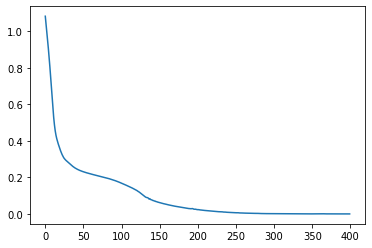

In [152]:
model = Net()
model.fit(x, y, epochs=400, verbose=False, plot=True)

In [153]:
loop()

> hi!
hi how be you
> i'm fine, and you?
shut be fine
> why are you shutting me?
i be fine you
> okay i understand
why be you shut me
> because of your fucking stupidness
okay i understand
> okay
why be alright
> because it's just alright, isn't it??
because your fucking
> fucking idiot!!!\
why be my alright
> stop sending me fucking stupid questions
okay german
> why fucking german???
because which
> fuck!
why be i alright
> because of me
fuck
> okay...
fuck be
> goodbye!
because be
> 
